In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
!wget https://tlk.s3.yandex.net/course/shad_cv_project_22/dataset_students.zip
!unzip dataset_students.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset_students/classification/train_unlabelled/6000.png  
  inflating: __MACOSX/dataset_students/classification/train_unlabelled/._6000.png  
  inflating: dataset_students/classification/train_unlabelled/6001.png  
  inflating: __MACOSX/dataset_students/classification/train_unlabelled/._6001.png  
  inflating: dataset_students/classification/train_unlabelled/6002.png  
  inflating: __MACOSX/dataset_students/classification/train_unlabelled/._6002.png  
  inflating: dataset_students/classification/train_unlabelled/6003.png  
  inflating: __MACOSX/dataset_students/classification/train_unlabelled/._6003.png  
  inflating: dataset_students/classification/train_unlabelled/6004.png  
  inflating: __MACOSX/dataset_students/classification/train_unlabelled/._6004.png  
  inflating: dataset_students/classification/train_unlabelled/6005.png  
  inflating: __MACOSX/dataset_students/classification/train_unlabelled/._6

In [4]:
!pip install -q pytorch-lightning wandb
!pip install ipyplot
!pip install timm

     |████████████████████████████████| 708 kB 31.6 MB/s 
     |████████████████████████████████| 1.9 MB 57.1 MB/s 
     |████████████████████████████████| 529 kB 68.1 MB/s 
     |████████████████████████████████| 5.9 MB 54.5 MB/s 
     |████████████████████████████████| 162 kB 70.8 MB/s 
     |████████████████████████████████| 182 kB 69.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 162 kB 71.8 MB/s 
     |████████████████████████████████| 158 kB 64.4 MB/s 
     |████████████████████████████████| 157 kB 73.7 MB/s 
     |████████████████████████████████| 157 kB 76.8 MB/s 
     |████████████████████████████████| 157 kB 75.6 MB/s 
     |████████████████████████████████| 157 kB 80.1 MB/s 
     |████████████████████████████████| 157 kB 76.7 MB/s 
     |████████████████████████████████| 157 kB 66.6 MB/s 
     |████████████████████████████████| 157 kB 77.7 MB/s 
     |████████████████████████████████| 156 kB 70.8 MB/s 
ERROR: pip's dep

In [5]:
!git clone https://github.com/alekseyen/TolokaCvProject.git

Cloning into 'TolokaCvProject'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 74 (delta 33), reused 70 (delta 29), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [6]:
!mv TolokaCvProject/* .

In [7]:
import pytorch_lightning as pl

In [8]:
import pandas as pd
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score
%matplotlib inline


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [9]:
from src.model import ImageClassifier
from src.utils import ImagesDataset, evaluate_model
from src.transforms import transform
from src import params

In [10]:
!nvidia-smi

Wed Oct 12 08:16:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load dataset

In [11]:
# train_df = pd.read_csv('dataset_students/classification/train_labelled.csv')
# train_df.head()

annotated0_df = pd.read_csv('train_labelled.tsv', sep='\t', index_col=None)
annotated0_df['OUTPUT:result'] = annotated0_df['GOLDEN:result']
annotated0_df = annotated0_df.drop('GOLDEN:result', axis=1)
annotated1_df = pd.read_csv('aggregated_results_by_ds__pool_35739415__2022_10_05.tsv', sep='\t', index_col=None)
annotated2_df = pd.read_csv('aggregated_results_by_ds__pool_35803045__2022_10_09.tsv', sep='\t', index_col=None)

train_df = pd.concat([annotated0_df, annotated1_df, annotated2_df]).drop('Unnamed: 3', axis=1)
train_df['INPUT:image'] = 'dataset_students/classification/train_' + train_df['INPUT:image']
train_df = train_df.fillna('100.00%').drop_duplicates()
train_df.head()

,INPUT:image,OUTPUT:result,CONFIDENCE:result
0,dataset_students/classification/train_labelled...,no,100.00%
1,dataset_students/classification/train_labelled...,other,100.00%
2,dataset_students/classification/train_labelled...,no,100.00%
3,dataset_students/classification/train_labelled...,no,100.00%
4,dataset_students/classification/train_labelled...,no,100.00%


In [12]:
len(train_df['INPUT:image']), len(set(train_df['INPUT:image'].to_list()))

(5900, 5900)

In [13]:
ids = train_df['INPUT:image']
train_df = train_df.drop(train_df[ids.isin(ids[ids.duplicated()])].index)
len(train_df['INPUT:image']), len(set(train_df['INPUT:image'].to_list()))

(5900, 5900)

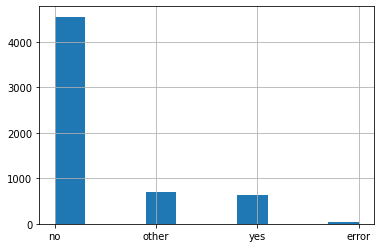

In [14]:
train_df['OUTPUT:result'].hist()

In [15]:
train_df['OUTPUT:result'] = train_df['OUTPUT:result'].map(dict(yes=1, no=0, other=2, error=2)).astype(int)

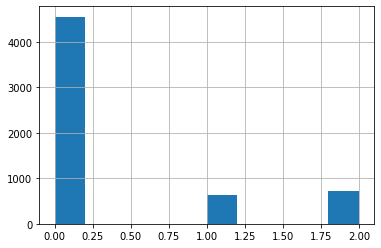

In [16]:
train_df['OUTPUT:result'].hist()

In [17]:
# train_image_paths = train_df.img_path.values
# train_labels = train_df.label.values


train_image_paths = train_df['INPUT:image'].values
train_labels = train_df['OUTPUT:result'].values

In [18]:
len(train_image_paths)

5900

In [ ]:
ipyplot.plot_class_tabs(train_image_paths, train_labels, max_imgs_per_tab = 10)

# Prepare model

In [19]:
!pip install imops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 12.1 MB/s 


In [20]:
train_dataset = ImagesDataset(train_image_paths, train_labels, transform=transform)

In [21]:
from imops import pad_to_shape, crop_to_shape
import numpy as np

def collate_batch(batch, dtype):
  label_list, images_list, shapes_list = [], [], []

  for (img, label, _) in batch:
    label_list.append(label)
    images_list.append(img)
    shapes_list.append(torch.tensor(img.shape))
   
  label_list = torch.tensor(label_list, dtype=torch.int64)
  max_shape = torch.stack(shapes_list).amax(axis=0)

  final_images = []
  for img in images_list:
    final_images.append(torch.tensor(crop_to_shape(pad_to_shape(img, np.maximum(max_shape.numpy(), (3, 224, 224))), (224, 224), axis=(-1, -2))))
  
  return torch.stack(final_images).to(dtype), label_list, None


In [22]:
from functools import partial

In [23]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           collate_fn=partial(collate_batch, dtype=torch.float16),
                                           batch_size=params.BATCH_SIZE,
                                           num_workers=2,
                                           shuffle=False)

In [24]:
# Run macos_cert_fix.py if you are getting ssl errors
import torch
model = ImageClassifier(learning_rate=params.LEARNING_RATE, class_weight=torch.tensor([1.0, 6.0, 1.0], device='cuda'))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv2_100_ra-b33bc2c4.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv2_100_ra-b33bc2c4.pth


In [25]:
#logger = WandbLogger(project='car_numbers', name='model_5857')


trainer = pl.Trainer(
    #logger=logger,
    max_epochs=params.MAX_EPOCHS,
    log_every_n_steps=1, # Change to enable tensorboard logging
    gpus=1, # Uncomment to use GPU training
    precision=16,
)
trainer.fit(model, train_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:109: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


# Compute training set accuracy

In [ ]:
labels, predictions, probas, idxs = evaluate_model(model, train_dataset)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f59b0fe6a70>
Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f59b0fe6a70>  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f59b0fe6a70>

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.

  0%|          | 0/185 [00:00<?, ?it/s]

Traceback (most recent call last):
    self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    
    if w.is_alive():  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    
if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
          File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():        assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():assert self._

RuntimeError: ignored

In [ ]:
ipyplot.plot_class_tabs(train_image_paths[idxs], predictions,)

In [ ]:
predictions = [0 if x == 2 else x for x in predictions ]
labels = [0 if x == 2 else x for x in labels ]

In [ ]:
f1_score(labels, predictions, labels=1, average='binary')

0.8771929824561403

![image.png](attachment:3ad7e37c-019b-471c-96e7-1ccd8cd0d7ef.png)

## Evaluate on val


In [26]:
!wget https://tlk.s3.yandex.net/course/shad_cv_project_22/val.zip

--2022-10-12 08:26:27--  https://tlk.s3.yandex.net/course/shad_cv_project_22/val.zip
Resolving tlk.s3.yandex.net (tlk.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to tlk.s3.yandex.net (tlk.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82653605 (79M) [application/zip]
Saving to: ‘val.zip’

val.zip             100%[===================>]  78.82M  10.3MB/s    in 9.5s    

2022-10-12 08:26:38 (8.28 MB/s) - ‘val.zip’ saved [82653605/82653605]



In [27]:
!unzip val.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: val/138.png             
  inflating: __MACOSX/val/._138.png  
  inflating: val/139.png             
  inflating: __MACOSX/val/._139.png  
  inflating: val/140.png             
  inflating: __MACOSX/val/._140.png  
  inflating: val/141.png             
  inflating: __MACOSX/val/._141.png  
  inflating: val/142.png             
  inflating: __MACOSX/val/._142.png  
  inflating: val/143.png             
  inflating: __MACOSX/val/._143.png  
  inflating: val/144.png             
  inflating: __MACOSX/val/._144.png  
  inflating: val/145.png             
  inflating: __MACOSX/val/._145.png  
  inflating: val/146.png             
  inflating: __MACOSX/val/._146.png  
  inflating: val/147.png             
  inflating: __MACOSX/val/._147.png  
  inflating: val/148.png             
  inflating: __MACOSX/val/._148.png  
  inflating: val/149.png             
  inflating: __MACOSX/val/._149.png  
  inflating: val/150

In [28]:
import os

full_image_paths = []

dataset_dir = 'val'

for file in os.listdir(dataset_dir):
    if file.endswith(".png"):
        full_image_paths += [os.path.join(dataset_dir, file)]


len(full_image_paths)

2638

In [29]:
other_part_dataset = ImagesDataset(full_image_paths, transform=transform)

labels, predictions = evaluate_model(model, other_part_dataset, collate_fn=partial(collate_batch, dtype=torch.float32))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/83 [00:00<?, ?it/s]

In [30]:
full_image_paths = [x.split('/')[-1] for x in full_image_paths]

In [31]:
predictions = [int(x == 1) for x in predictions]

In [32]:
df = pd.DataFrame(dict(img_path=full_image_paths, label = predictions))

df.head(10)

,img_path,label
0,1318.png,0
1,1856.png,0
2,1914.png,0
3,2331.png,0
4,433.png,0
5,2353.png,0
6,1005.png,0
7,1263.png,0
8,367.png,0
9,98.png,0


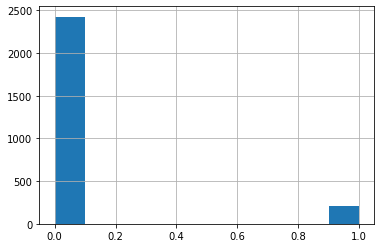

In [ ]:
df['label'].hist()

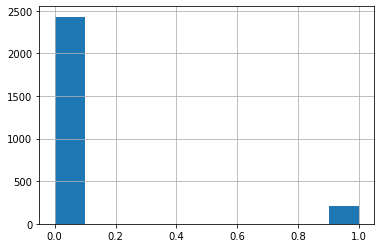

In [33]:
df['label'].hist()

In [34]:
df.to_csv('results.csv', index=False, sep=',')

In [35]:
trainer.save_checkpoint("model.ckpt")